####    From this notebook we creat representative waterway network for corridor bunkering plan        

### 
We add some properties to the graph (depth) and the vessel (VesselProperties, ConsumesEnergy) in order to calculate resistance, required power, 

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             

# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

import logging
#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph
We first need to create a 1D network (a graph) along which the vessel will move. A graph contains edges (blue dots in plot below) and vertices (black lines in plot below). For this example, we will construct a network consisting of 4 nodes in a straight line. Since we would like to have two-way traffic, we add two edges between each pair of nodes: one from left to right, and another the other way around (however, we could easily apply one-way traffic as well by remove one of the two edges). Consequently, we arrive at a total of 4 nodes, and 6 edges.

Due to the nature of discrete modelling in which the time step is dependent on the activities (in this example: forcing a ship to move from node to node from its origin to its destination), it is important to add OpenTNSim mix-ins to the nodes in such a way we could identify the node (mix-in Identifiable, which imports a name and imports/creates an ID), and to locate the node (mix-in Locatable, which gives the node a geometry).


In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
          [0,0], [0.8983, 0], [1.7966,0], [1.7966,1.3566], [1.7966,2.2609],
          [0,0], [0.8983, 0], [1.7966,0], [2.7527,0.9560], [3.3903,1.5931],
          [0,0], [0.8983, 0], [1.7966,0], [3.1441,0], [4.0424,0],
          [0,0], [0.8983, 0], [1.7966,0], [1.9560,-0.1593], [3.3904,-1.5931],
          ] 

# # for each edge (between above coordinates) specify the depth (m)
# depths = [12.5, 4.5, 16, 0, 6, 6, 6, 0, 4.5, 6, 0, 2.5, 6, 0, 2.5, 6, 0, 4.5, 4.5 ]                                                                                                                      

# # check of nr of coords and nr of depths align
# assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [14]:
# create a graph based on coords and depths
def create_sample_network():
    FG = nx.DiGraph()
    nodes = []
    path = []

    # add nodes
    Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

    for index, coord in enumerate(coords):
        data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
        nodes.append(Node(**data_node))

    positions = {}
    for node in nodes:
        positions[node.name] = (node.geometry.x, node.geometry.y)
        FG.add_node(node.name, geometry = node.geometry)

    # add edges
    path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]
    path.remove([nodes[4],nodes[5]])
    path.remove([nodes[9],nodes[10]])
    path.remove([nodes[14],nodes[15]])

    depths = [12.5, 6, 6, 6, 12.5, 6, 4.5, 6, 12.5, 6, 2.5, 6, 12.5, 6, 2.5, 6 ]
    lengths = [100, 100, 150, 100, 100, 100, 150, 100, 100, 100, 150, 100, 100, 100, 25, 225]
    widths = [300, 150, 150, 150, 300, 150, 150, 150, 300, 150, 150, 150, 300, 150, 150, 150]

    for index, edge in enumerate(path):
        # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
        # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
        #     this may not be very generic!
        FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": depths[index],
                                                                    "GeneralLength": lengths[index],
                                                                    "GeneralWidth":widths[index]})


    # toggle to undirected and back to directed to make sure all edges are two way traffic
    FG = FG.to_undirected() 
    FG = FG.to_directed() 
    return FG

In [15]:
FG = create_sample_network()

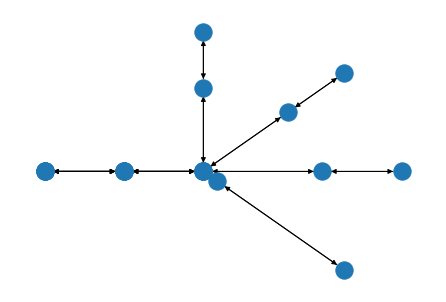

In [16]:
# show graph
nx.draw(FG, positions)
plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth  for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('General length for edge {} is {} km'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralLength"]))
    print('General width  for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralWidth"]))

General depth  for edge ('Node 0', 'Node 1') is 12.5 m
General length for edge ('Node 0', 'Node 1') is 100 km
General width  for edge ('Node 0', 'Node 1') is 300 m
General depth  for edge ('Node 1', 'Node 0') is 12.5 m
General length for edge ('Node 1', 'Node 0') is 100 km
General width  for edge ('Node 1', 'Node 0') is 300 m
General depth  for edge ('Node 1', 'Node 2') is 6 m
General length for edge ('Node 1', 'Node 2') is 100 km
General width  for edge ('Node 1', 'Node 2') is 150 m
General depth  for edge ('Node 2', 'Node 1') is 6 m
General length for edge ('Node 2', 'Node 1') is 100 km
General width  for edge ('Node 2', 'Node 1') is 150 m
General depth  for edge ('Node 2', 'Node 3') is 6 m
General length for edge ('Node 2', 'Node 3') is 150 km
General width  for edge ('Node 2', 'Node 3') is 150 m
General depth  for edge ('Node 3', 'Node 2') is 6 m
General length for edge ('Node 3', 'Node 2') is 150 km
General width  for edge ('Node 3', 'Node 2') is 150 m
General depth  for edge ('No

### Create vessel - add VesselProperties and ConsumesEnergy mixins
The following mix-ins are required for each vessel in our problem: Identifiable (gives the vessel a name and a random ID), Movable (gives that the object (*vessel*) can move with a fixed speed and logs this activity, it requires input for the following mix-ins: Locatable, Routeable, and Log), and Routable (gives the object a route). We now modify our original vessel from the basic example and include vessel properties (like width, length, etc.) and a mixin that is needed to calculate resistance and energy consumption. 

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later
# Note that we set "h_squat" as "True". 
# The squat effect makes a great difference for the actual water depth and resistance calculation in shallow water. 
# Here we need to calculate the water depth reduced by squat since what we give the ship is a route with undisturbed water depth h_0.

data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 3.5,  # m/s
               "type":None,
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "safety_margin": 0.2, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
               "h_squat": True, # if consider the ship squat while moving, set to True, otherwise set to False. 
               "P_installed": 1750.0,
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2 ,
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }             

vessel = TransportResource(**data_vessel)

### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [8]:
paths = []
path_0 = nx.dijkstra_path(FG, nodes[0].name, nodes[4].name)
path_1 = nx.dijkstra_path(FG, nodes[5].name, nodes[9].name)
path_2 = nx.dijkstra_path(FG, nodes[10].name, nodes[14].name)
path_3 = nx.dijkstra_path(FG, nodes[15].name, nodes[19].name)
paths = [path_0, path_1, path_2, path_3]

### Run simulation
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

In [9]:
def run_simulation(V_s, T, paths):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = paths                                    #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[paths[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()
    print (vessel._T)
    return vessel

In [10]:
input_data = {'V_s': [3.5, 3.5, 3.5, 3.5], 'T':[2.05, 2.05, 2.05, 2.05], 'paths': [path_0, path_1, path_2, path_3]}
input_data

{'V_s': [3.5, 3.5, 3.5, 3.5],
 'T': [2.05, 2.05, 2.05, 2.05],
 'paths': [['Node 0', 'Node 1', 'Node 2', 'Node 3', 'Node 4'],
  ['Node 5', 'Node 6', 'Node 7', 'Node 8', 'Node 9'],
  ['Node 10', 'Node 11', 'Node 12', 'Node 13', 'Node 14'],
  ['Node 15', 'Node 16', 'Node 17', 'Node 18', 'Node 19']]}

In [11]:
# create empty plot data
plot_data = {}

# loop through the various input data
for index, value in enumerate(input_data['V_s'],):
    #print("value", value)   
    # Run a basic simulation with V_s and P_tot_given combi

    vessel = run_simulation(input_data['V_s'][index], input_data['T'][index], input_data['paths'][index])

    # create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    # create dataframe from energy calculation computation
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    display(df)
#     # add/modify some comlums to suit our plotting needs
   
#     df['fuel_kg_per_km'] = (df['total_fuel_consumption']/1000) / (df['distance']/1000)
#     df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
#     df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
#     df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)
    
#     label = 'V_s = ' + str(input_data['V_s'][index]) + ' P_tot_given = ' + str(input_data['P_tot_given'][index])

#     # Note that we make a dict to collect all plot data. 
#     # We use labels like ['V_s = None P_tot_given = 274 fuel_kg_km'] to organise the data in the dict
#     # The [0, 0, 1, 1, 2, 2] below creates a list per section 
#     plot_data[label + ' P_tot']   = list(df.P_tot[[0, 0, 1, 1, 2, 2]])
#     plot_data[label + ' fuel_kg_per_km']   = list(df.fuel_kg_per_km[[0, 0, 1, 1, 2, 2]])
#     plot_data[label + ' CO2_g_per_km'] = list(df.CO2_g_per_km[[0, 0, 1, 1, 2, 2]])
#     plot_data[label + ' PM10_g_per_km']   = list(df.PM10_g_per_km[[0, 0, 1, 1, 2, 2]])
#     plot_data[label + ' NOx_g_per_km']   = list(df.NOx_g_per_km[[0, 0, 1, 1, 2, 2]])
        

2.05


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,time_start,time_stop,edge_start,edge_stop,P_tot,P_installed,total_energy,total_fuel_consumption,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2022-04-05 21:55:31.000000,2022-04-06 05:51:41.942451,POINT (0 0),POINT (0.8983 0),387.981317,1750.0,3079.164413,7.731476e+05,2.452987e+06,1428.258030,33669.538444,0,12.434512,99998.298580,28570.942451
1,2022-04-06 05:51:41.942451,2022-04-06 13:47:52.884902,POINT (0.8983 0),POINT (1.7966 0),390.699211,1750.0,3100.734633,7.781399e+05,2.468826e+06,1435.566500,33866.490105,0,5.881326,99998.298580,28570.942451
2,2022-04-06 13:47:52.884902,2022-04-07 01:42:11.554625,POINT (1.7966 0),POINT (1.7966 1.3566),390.699211,1750.0,4651.346793,1.167271e+06,3.703434e+06,2153.463107,50802.409352,0,5.881326,150005.344027,42858.669723
3,2022-04-07 01:42:11.554625,2022-04-07 09:38:21.079982,POINT (1.7966 1.3566),POINT (1.7966 2.2609),390.699211,1750.0,3100.580840,7.781013e+05,2.468703e+06,1435.495297,33864.810355,0,5.881326,99993.338749,28569.525357


2.05


AssertionError: D should be > 0: nan

### plot energy consumption on the graph